In [2]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train_1.csv')

In [5]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,...,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,10.0,...,21.0,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,12.0,...,14.0,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,4.0,...,3.0,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,8.0,...,15.0,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.0,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


#### Transforming the data

In [6]:
train.shape

(145063, 551)

In [10]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date',
                          value_name='Visits')
train_flattened['date'] = pd.to_datetime(train_flattened['date'])
train_flattened['weekend'] = (train_flattened.date.dt.dayofweek // 5 == 1).astype('float')
train_flattened.sample(5)

,Page,date,Visits,weekend
5310287,ハロウィン_ja.wikipedia.org_desktop_all-agents,2016-12-18,283.0,1.0
1630091,The_Empire_Strikes_Back_en.wikipedia.org_all-a...,2016-11-23,30.0,0.0
1069175,Jour_d'Arafat_fr.wikipedia.org_mobile-web_all-...,2016-11-19,13.0,1.0
78272,"File:Desteapta-te,_romane!.ogg_commons.wikimed...",2016-11-12,0.0,1.0
4659145,"Вулф,_Томас_ru.wikipedia.org_mobile-web_all-ag...",2016-12-14,331.0,0.0


In [13]:
train_flattened.groupby(['Page']).median()

,Visits,weekend
Page,,
!vote_en.wikipedia.org_all-access_all-agents,2.0,0.0
!vote_en.wikipedia.org_all-access_spider,1.0,0.0
!vote_en.wikipedia.org_desktop_all-agents,2.0,0.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",6213.0,0.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",61.0,0.0
...,...,...
대문_commons.wikimedia.org_desktop_all-agents,171.0,0.0
［Alexandros］_ja.wikipedia.org_all-access_all-agents,3747.0,0.0
［Alexandros］_ja.wikipedia.org_all-access_spider,273.0,0.0


#### Statistics

In [19]:
# median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

,median
Page,
!vote_en.wikipedia.org_all-access_all-agents,2.0
!vote_en.wikipedia.org_all-access_spider,1.0
!vote_en.wikipedia.org_desktop_all-agents,2.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",6213.0
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",61.0


In [20]:
# mean by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

,mean
Page,
!vote_en.wikipedia.org_all-access_all-agents,2.836735
!vote_en.wikipedia.org_all-access_spider,1.612245
!vote_en.wikipedia.org_desktop_all-agents,2.510204
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_all-agents",8959.833333
"""Awaken,_My_Love!""_en.wikipedia.org_all-access_spider",107.750000


In [24]:
train_flattened = train_flattened.set_index('Page').join([
    df_mean,df_median])
train_flattened.reset_index(inplace=True)
train_flattened.head()

,Page,date,Visits,weekend,mean,median
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0


#### Feature engineering

In [25]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())
train_flattened['year'] = train_flattened['date'].dt.year
train_flattened['month'] = train_flattened['date'].dt.month
train_flattened['day'] = train_flattened['date'].dt.day

train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


#### Visualisation

Text(0.5, 1.0, 'Time Series - Average')

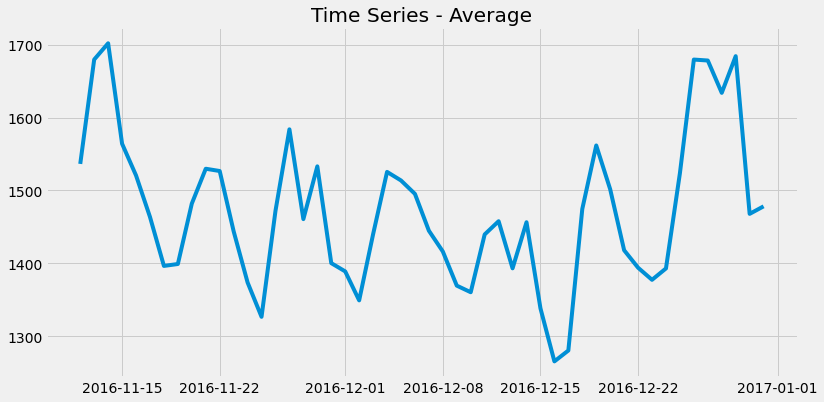

In [29]:
mean_group = train_flattened[['Page','date','Visits']].groupby('date')['Visits'].mean()
plt.figure(figsize=(12,6))
plt.plot(mean_group)
plt.title('Time Series - Average')

Text(0.5, 1.0, 'Time Series - Median')

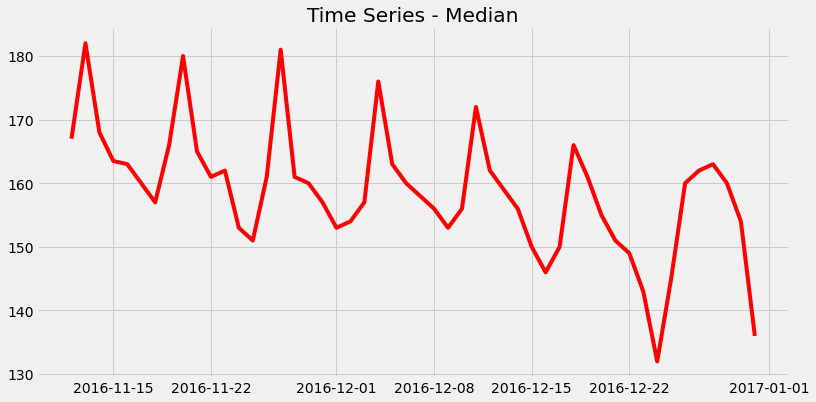

In [31]:
median_group = train_flattened[['Page','date','Visits']].groupby('date')['Visits'].median()
plt.figure(figsize=(12,6))
plt.plot(median_group, color='red')
plt.title('Time Series - Median')

Text(0.5, 1.0, 'Time Series - STD')

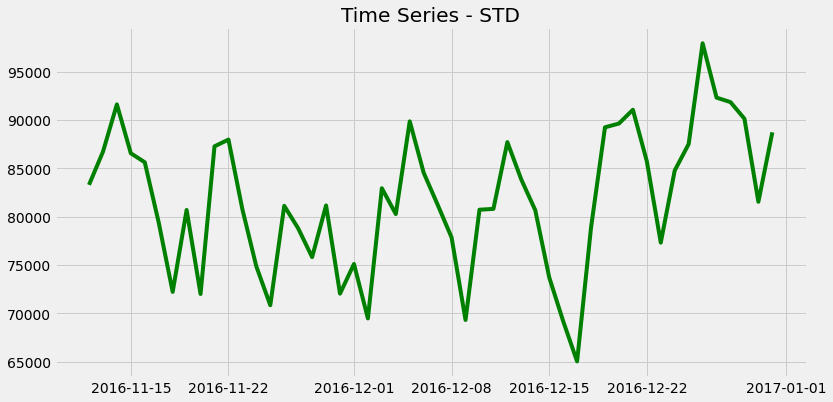

In [32]:
std_group = train_flattened[['Page','date','Visits']].groupby('date')['Visits'].std()
plt.figure(figsize=(12,6))
plt.plot(std_group, color='green')
plt.title('Time Series - STD')